# <center>Лекція 6. Побудова й відбір ознак</center>

<a class="anchor" id="6"></a>

## Зміст

- [6.1. Виявлення ознак (Feature extraction)](#6.1)
    + [6.1.1. Тексти](#6.1.1)
    + [6.1.2. Зображення](#6.1.2)
    + [6.1.3. Геодані](#6.1.3)
    + [6.1.4. Дата та час](#6.1.4)
    + [6.1.5. Часові ряди, веб та інше](#6.1.5)   
- [6.2. Перетворення ознак (Feature transformations)](#6.2)
    + [6.2.1. Нормалізація та зміна розподілу](#6.2.1)
    + [6.2.2. Взаємодія (Interactions)](#6.2.2)
    + [6.2.3. Заповнення пропусків](#6.2.3) 
- [6.3. Відбір ознак (Feature selection)](#6.3)
    + [6.3.1. Статистичні підходи](#6.3.1)
    + [6.3.2. Відбір із використанням моделей](#6.3.2)
    + [6.3.3. Перебір](#6.3.2)

- [6.4. Основні метрики якості класифікації](#6.4)
    + [6.4.1. Матриця невідповідностей](#6.4.1)
    + [6.4.2. Характеристики бінарного класифікатора](#6.4.2)
    + [6.4.3. ROC-крива та AUC](#6.4.3)
    + [6.4.4. Дисбаланс класів](#6.4.4)
    + [6.4.5. Приклади застосувань метрик класифікації](#6.4.5)
    + [6.4.6. Багатокласова класифікація](#6.4.6)
    + [6.4.7. One vs. All](#6.4.7)
- [6.5. Корисні посилання](#6.5)

В рамках курсу ми вже познайомилися з кількома ключовими алгоритмами машинного навчання (МН) для оброблення статистичних даних. Проте перед тим як переходити до більш складних алгоритмів та статистичних підходів, скажимо кілька слів про підготовку даних для навчання моделі.

Відомий принцип garbage in - garbage out є на 100% застосовуваним щодо будь-якого завдання МН. Будь-який досвідчений інженер може згадати приклади з практики, коли проста модель, навчена на якісно підготовлених даних, показала себе краще хитромудрого ансамблю, побудованого на недостатньо чистих даних.

В поточній лекції розглянемо три схожих завдання в задачі підготовки та оброблення ознак:
* **feature extraction** і **feature engineering**, з англ. мови "виявлення ознак" – це перетворення даних, специфічних для предметної області, у вектори, що є зрозумілими для моделі;
* **feature transformation**, з англ. мови "перетворення ознак" – це трансформація даних для підвищення точності алгоритму;
* **feature selection** з англ. мови "відбір ознак" – це відбір найбільш значущих ознак або відсікання непотрібних ознак.

У прикладах до лекції будемо використовувати набір даних компанії Renthop із Kaggle-змагання [Two Sigma Connect: Rental Listing Inquiries Kaggle competition](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries).

У цьому завданні потрібно передбачити популярність оголошення щодо оренди нерухомості, тобто розв'язати задачу класифікації з трьома класами `['low', 'medium', 'high']`. Для оцінки розв'язку використовується метрика log loss (чим менше – тим краще). 

Для інсталювання необхідного пакету в середовищі Anaconda потрібно в терміналі ввести наступні команди:

```python
!pip install user-agents
!pip install mlxtend
```

Те ж саме, але `conda-forge` (як можлива альтернатива):

```python
conda install -c conda-forge mlxtend
conda install -c conda-forge user-agents
```

In [1]:
from __future__ import division, print_function
# Відключимо попередження Anaconda
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load Renthop dataset and configure plot settings for clarity
df = pd.read_json('train.json')  # Directly load JSON into DataFrame

# Set inline plotting and configure styles for better visualization
%matplotlib inline
plt.style.use('ggplot')
# plt.rcParams.update({'figure.figsize': (7, 5), 'savefig.format': 'svg'})

<a class="anchor" id="6.1"></a>

## <span style="color:blue; font-size:1.2em;">6.1. Виявлення ознак (Feature extraction)</span>

[Повернутися до змісту](#6)

На практиці вкрай рідко дані отримують у вигляді готових матриць. Тому будь-яка задачі розпочинається з виявлення ознак.

Іноді набір даних для розв'язування задачі є підготовленим заздалегідь.В такому разі достатньо прочитати `.csv` файл і конвертувати його в `numpy.array`.

Проте це, на жаль, такі випадки є вкрай винятковими, коли хтось інший поторбувався за підготовку даних. Тому щоби навчитися готувати дані для моделювання, розглянемо найбільш популярні типи даних, з яких зазвичай вилучають ознаки.

<a class="anchor" id="6.1.1"></a>

### <span style="color:blue; font-size:1.2em;"> 6.1.1. Текстові дані</span>

[Повернутися до змісту](#6)

Текст – найбільш очевидний приклад даних у вільному форматі. Методів роботи з текстом дуже багато, в одній лекції вони не помістяться. Тим не менш, оглядово розглянемо найпопулярніші.

- Перед тим, як працювати з текстом, його необхідно [токенізувати](https://neptune.ai/blog/tokenization-in-nlp).
- Токенізація передбачає розбиття тексту на так звані токени – у найпростішому випадку це слова. Проте надто спрощуючи це поняття ми можемо втратити частину сенсу, наприклад, назва містечка "Велика Рогань" це не два токена, а один. Втім заклик "кради-вбивай!" даремно розділяти на два токени, тут два слова позначають один сенс.
- Існують готові токенайзери, які враховують особливості мови, але й вони можуть помилятися, особливо якщо ви працюєте зі специфічними текстами (професійна лексика, жаргонізми, друкарські помилки тощо).

Після токенізації зазвичай потрібно проводити [нормалізацію](https://en.wikipedia.org/wiki/Normalization_(statistics). Тут мова йде за [стемінг](https://en.wikipedia.org/wiki/Stemming) та/або [лематизацію](https://en.wikipedia.org/wiki/Lemmatisation) – це схожі процеси, що використовуються для оброблення словоформ. Про різницю між ними можна прочитати [тут](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).

Отже, після перетворення текстового документа на послідовність слів, можна починати перетворювати їх на вектора. Найпростіший підхід називається [Bag of Words](https://www.freecodecamp.org/news/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04/): створюємо вектор довжиною у словник, для кожного слова обраховуємо кількість входжень у текст та підставляємо це число на відповідну позицію у векторі. Ідея підходу добре ілюструється таким зображенням:

<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_1_bag-of-words.png" align="center" width=80% height=80%>

Програмний код цього механізму виглядає навіть простіше, ніж звучить на словах:

In [3]:
from functools import reduce
import numpy as np
from collections import Counter

texts = [['i', 'have', 'a', 'cat'], 
         ['he', 'have', 'a', 'dog'], 
         ['he', 'and', 'i', 'have', 'a', 'cat', 'and', 'a', 'dog']]

In [4]:
# Створюємо словник, що зіставляє кожному слову його індекс
dictionary = {word: i for i, word in enumerate(set(reduce(lambda x, y: x + y, texts)))}

def vectorize(text):
    # Використовуємо Counter для підрахунку частоти слів у тексті
    word_count = Counter(text)
    # Створюємо вектор, базуючись на індексах із словника
    return np.array([word_count.get(word, 0) for word in dictionary])

# Виводимо векторне представлення для кожного тексту
for t in texts:
    print(vectorize(t))

[1 1 1 0 0 0 1]
[0 0 1 0 1 1 1]
[1 1 2 2 1 1 1]


На практиці потрібно подбати про стоп-слова, максимальний розмір словника та ефективну структуру даних (зазвичай текстові дані перетворюють на розріджені вектори).

Водночас використання алгоритмів на кшталт Вag of Words призводить до втрати порядку слів у тексті, тобто, тексти "i have no cows" та "no, i have cows" будуть ідентичними після векторизації, хоча і протилежними семантично. Щоб уникнути цієї проблеми, можна зробити крок назад і змінити підхід до токенізації: наприклад використовувати [n-грами](https://uk.wikipedia.org/wiki/N-%D0%B3%D1%80%D0%B0%D0%BC%D0%B0) (*комбінації* з N послідовних термінів).

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,1))
vect.fit_transform(['no i have cows', 'i have no cows']).toarray()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int64)

In [6]:
vect.vocabulary_ 

{'no': 2, 'have': 1, 'cows': 0}

In [7]:
vect = CountVectorizer(ngram_range=(1,2))
vect.fit_transform(['no i have cows', 'i have no cows']).toarray()

array([[1, 1, 1, 0, 1, 0, 1],
       [1, 1, 0, 1, 1, 1, 0]], dtype=int64)

In [8]:
vect.vocabulary_

{'no': 4,
 'have': 1,
 'cows': 0,
 'no have': 6,
 'have cows': 2,
 'have no': 3,
 'no cows': 5}

Також варто зазначити, що необов'язково оперувати саме словами: у деяких випадках можна генерувати N-грами з літер. Наприклад, такий алгоритм врахує схожість споріднених слів або друкарських помилок.

In [9]:
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import CountVectorizer

# Створюємо векторизатор з n-грамами довжиною 3 символи з урахуванням пробілів (char_wb)
vect = CountVectorizer(ngram_range=(3, 3), analyzer='char_wb')
# Перетворюємо імена на вектори характеристик та розділяємо їх на окремі змінні
n1, n2, n3, n4 = vect.fit_transform(['andersen', 'petersen', 'petrov', 'smith']).toarray()
# Обчислюємо евклідові відстані між векторними поданнями імен
distance_1_2 = euclidean(n1, n2)
distance_2_3 = euclidean(n2, n3)
distance_3_4 = euclidean(n3, n4)

distance_1_2, distance_2_3, distance_3_4

(2.8284271247461903, 3.1622776601683795, 3.3166247903554)

Розвиток ідеї Bag of Words: слова, які рідко зустрічаються в корпусі (у всіх документах цього набору даних), але присутні в цьому конкретному документі, можуть виявитися більш важливими.

В такому разі варто підвищити вагу більш вузькотематичних слів, щоб відокремити їх від загальнотематичних. Цей підхід називається [TF-IDF](https://uk.wikipedia.org/wiki/TF-IDF). Варіант TF-IDF за замовчуванням виглядає так:

\begin{equation}
\text{IDF}(t, D) = \log \left( \frac{|D|}{\text{df}(d, t) + 1} \right),
\end{equation}

\begin{equation}
\text{TF-IDF}(t, d, D) = \text{tf}(t, d) \times \text{IDF}(t, D).
\end{equation}

Аналоги підходу Bag of words можуть зустрічатися й поза текстовими задачами: наприклад, bag of sites в [Catch Me If You Can competition](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking), [Bag of apps](https://www.kaggle.com/xiaoml/talkingdata-mobile-user-demographics/bag-of-app-id-python-2-27392), [Bag of events](https://www.gelbukh.com/ijcla/2015-2/IJCLA-2015-2.pdf#page=11) тощо.

Використання таких алгоритмів дає змогу отримати цілком робоче рішення простої проблеми, так званий baseline (з англ. "початкове рішення"). Проте, для тих дослідників/інженерів, які полюбляють щось більш сучасне, на ринку доступні нові підходи. Найпопулярніший метод нової хвилі – [Word2Vec](https://towardsdatascience.com/word2vec-explained-49c52b4ccb71), але є й альтернативи ([Wang2Vec](https://github.com/wlin12/wang2vec), [Glove](https://medium.com/analytics-vidhya/word-vectorization-using-glove-76919685ee0b), [fastText](https://fasttext.cc/)).

Word2Vec є частинним випадком алгоритмів Word Embedding. Використання Word2Vec та подібних підходів дає змогу не лише векторизувати слова у просторі великої розмірності (зазвичай кілька сотень), а й порівнювати їхню семантичну близькість. Класичний приклад операцій над векторизованими поданнями: ***king – man + woman = queen***.

<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_2_king-man%2Bwoman.gif" align="center" width=50% height=50%>

Варто розуміти, що ця модель не володіє розумінням слів, а лише намагається розмістити вектори так, щоб слова, які вживаються в загальному контексті, розміщувалися недалеко один від одного. Якщо цього не враховувати, можуть виникати багато курйозів: наприклад, знайти протилежність Гітлеру через множення відповідного вектора на -1.

Такі моделі мають навчатися на великих наборах даних, щоб координати векторів дійсно відображали семантику слів. Для розв'язування власних задач можна завантажити напереднавчену модель, наприклад, [тут](https://github.com/3Top/word2vec-api#where-to-get-a-pretrained-models).

Схожі методи використовуються також в інших областях (наприклад, у біоінформатиці). З несподіваних застосувань – [food2vec](https://jaan.io/food2vec-augmented-cooking-machine-intelligence/). Ви також можете свої ідеї; концепція досить універсальна.

<a class="anchor" id="6.1.2"></a>

### <span style="color:blue; font-size:1.2em;">6.1.2. Зображення</span>

[Повернутися до змісту](#6)

Робота із зображеннями стає все простішою з року в рік. Перш за все, тому що часто можна взагалі не думати, а просто використати одну з популярних нейронних мереж. Втім, тут також не без проблем: для доволі складних задач із обробленням зображень потрібно багато чого знати.

У часи, коли [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit) були слабшими, а "ренесанс нейромереж" ще не трапився, генерація візуальних ознак із зображень була окремою досить складною підгалуззю.

Для роботи із зображеннями потрібно було працювати на низькому рівні, визначаючи, наприклад, кути, границі об'єктів тощо. Досвідчені фахівці у галузі комп'ютерного зору могли б провести багато паралелей між традиційними (старішими) підходами та сучасним нейромережевим моделюванням: зокрема, згорткові шари в сучасних мережах дуже схожі на [каскади Хаара](https://en.wikipedia.org/wiki/Haar-like_feature). Залишимо кілька посилань на популярні в минулому бібліотеки [skimage](http://scikit-image.org/docs/stable/api/skimage.feature.html) та [SimpleCV](http://simplecv.readthedocs.io/en/latest/SimpleCV.Features.html) і перейдемо відразу до теперішнього часу.

- Для задач з обробленням зображень часто використовують згорткову нейронну мережу. 
- Немає потреби створювати архітектуру з нуля — можна скористатися напереднавченою "state of the art" мережею, ваги якої доступні у відкритих джерелах.
- Адаптація під свою задачу здійснюється методом "fine tuning".
- Fine tuning включає заміну останніх повнозв'язних шарів на нові, що відповідають конкретній задачі, та донавчання мережі на нових даних.
- Якщо зображення потрібно векторизувати для інших цілей, можна просто видалити останні шари й використовувати вихідну інформацію попередніх шарів.

In [10]:
# За бажання цей код можна роздокоментувати та подивитися
# на результат застосування бібліотеки PyTorch

# import torch
# from torchvision import models, transforms
# from PIL import Image
# import numpy as np
# from scipy.misc import face

# # Визначення трансформацій зображення
# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Завантаження попередньо підготовленої моделі ResNet50
# resnet = models.resnet50(pretrained=True)
# resnet.eval()  # Set the model to evaluation mode

# # Завантаження та попереднє оброблення зображення
# img = Image.fromarray(face())  # Convert numpy array to PIL Image
# img = img.convert('RGB')  # Convert to RGB if necessary
# img = transform(img)

# # Додавання додаткового виміру
# img = img.unsqueeze(0)

# # Прогноз
# with torch.no_grad():
#     features = resnet(img)


<figure>
<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_3_neural-net.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><i>Згорткова нейронна мережа - типовий приклад архітектури нейронної мережі, що містить у собі як блоки для виявлення ознак, так і блоки для класифікації отриманого вектора ознак</i></figcaption>
</figure>

Проте не варто зациклюватися лише на нейромережевих методах. Деякі ознаки, згенеровані руками, можуть виявитися корисними і тепер: наприклад, прогнозуючи популярність оголошень про оренду квартири, можна припустити, що світлі квартири більше привертають увагу, і оформити ознаку "середнє значення пікселя". Надихнутися прикладами можна у документації відповідних [бібліотек](http://pillow.readthedocs.io/en/3.1.x/reference/ImageStat.html).

Якщо на зображенні очікується блоки з текстом, то його можна прочитати й без розгортання складних нейромереж власними руками: наприклад, за допомогою [pytesseract](https://github.com/madmaze/pytesseract).

```python
import pytesseract
from PIL import Image
import requests
from io import BytesIO

# Випадкове зображення з інтернет-пошуку
img = 'http://ohscurrent.org/wp-content/uploads/2015/09/domus-01-google.jpg'

img = requests.get(img)
img = Image.open(BytesIO(img.content))
text = pytesseract.image_to_string(img)

text

Out: 'Google'
```

Варто пам'ятати, що `pytesseract` – не панацея:

```python
# Цього разу беремо зображення з Renthop
img = requests.get('https://photos.renthop.com/2/8393298_6acaf11f030217d05f3a5604b9a2f70f.jpg')
img = Image.open(BytesIO(img.content))
pytesseract.image_to_string(img)

Out: 'Cunveztible to 4}»'
```

Ще один випадок, коли нейронні мережі не допоможуть – виявлення ознак з метаінфорації. В EXIF може зберігатися багато корисного: виробник і модель камери, дозвіл, використання спалаху, геокоординати зйомки, використане для оброблення програмне забезпечення та багато іншого.

<a class="anchor" id="6.1.3"></a>

### <span style="color:blue; font-size:1.2em;"> 6.1.3. Геодані</span>

[Повернутися до змісту](#6)

* Географічні дані менш поширені в задачах, ніж інші типи даних, але варто освоїти основні методи роботи з ними, оскільки є багато готових рішень.
* Геодані зазвичай представлені у вигляді адрес або пар "широта + довгота", тобто як точки на карті.
* Залежно від задачі, можуть знадобитися:
   - Геокодування (перетворення адреси на координати)
   - Зворотне геокодування (перетворення координат на адресу)
* Для геокодування та зворотного геокодування використовуються зовнішні API, такі як Google Maps або OpenStreetMap.
* Геокодери відрізняються за якістю в різних регіонах, тому варто обирати відповідний сервіс.
* Існують універсальні бібліотеки, як-от [geopy](https://github.com/geopy/geopy), що є обгорткою над багатьма геокодувальними сервісами, спрощуючи роботу з ними.

Якщо даних багато, то зовнішні API можуть спричиняти різні обмеження та проблеми. А для отримання інформації за HTTP далеко не завжди є оптимальнм рішенням за швидкостю. Тому варто пам’ятати про можливість використання локальної версії OpenStreetMap.

Якщо даних мало, часу достатньо, але немає бажання вилучати складні ознаки, то можна не "гратися" з OpenStreetMap і використати `reverse_geocoder`:

```python
import reverse_geocoder as revgc

revgc.search((df.latitude, df.longitude))
Loading formatted geocoded file... 

Out: [OrderedDict([('lat', '40.74482'), 
                   ('lon', '-73.94875'), 
                   ('name', 'Long Island City'), 
                   ('admin1', 'New York'), 
                   ('admin2', 'Queens County'), 
                   ('cc', 'US')])]
```

* Під час роботи з геокодуванням слід враховувати, що адреси можуть містити помилки, тож потрібна попередня очистка даних.
* У координатах менше друкарських помилок, але проблеми можливі:
   - GPS може "шуміти", особливо в місцях з поганим сигналом, наприклад, у тунелях або районах з високими будівлями.
   - Якщо джерело – мобільний пристрій, геолокація може визначатися за мережами Wi-Fi, що призводить до "дірок" і можливих "телепортацій" точок між далекими місцями.

* **Гіпотеза про телепортацію**: Враховуючи, що точки зазвичай розташовані серед інфраструктури, можна додати ознаки, що базуються на навколишньому середовищі:
   - Близькість до метро, поверховість будівель, відстань до магазинів, кількість банкоматів у радіусі тощо.
* Для завдань поза міською інфраструктурою доцільно використовувати спеціалізовані ознаки, як-от висота над рівнем моря. 

* Отже, додавання контекстуальних ознак із зовнішніх джерел дозволяє точніше аналізувати та інтерпретувати геодані.

Якщо дві або більше точок взаємопов'язані, то можливо, варто вилучати ознаки маршруту між ними.

Тут знадобляться дистанції (варто дивитися і на great circle distance, і на "чесну" відстань, обраховану за дорожнім графом), кількість поворотів разом із співвідношенням лівих та правих, кількість світлофорів, розв'язок, мостів тощо.

Наприклад, непогано може спрацювати ознака під назвою "складність дороги" – це відстань, що обрахована за графом і поділена на GCD.

<a class="anchor" id="6.1.4"></a>

### <span style="color:blue; font-size:1.2em;">6.1.4. Дата і час </span>

[Повернутися до змісту](#6)

Здавалося б, робота з датою і часом має бути стандартизована через поширеність відповідних ознак, але тут також не без проблем.

Почнемо з днів тижня – їх легко перетворити на 7 "dummy" змінних за допомогою "one-hot" кодування. Крім цього, корисно виділити окрему ознаку`is_weekend`.

```python
df['dow'] = df['created'].apply(lambda x: x.date().weekday())
df['is_weekend'] = df['created'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)
```

Деякі практичні задачі можуть потребувати додаткові календарні ознаки: наприклад, зняття готівки може бути прив'язане до дня видачі зарплат, а придбання проїзного – до початку місяця. Водночас, працюючи з часовими даними, треба мати під рукою календар із державними святами, аномальними погодними умовами та іншими важливими подіями.

Професійний несмішний гумор:

> Q: Що спільного між китайським новим роком, нью-йорським марафоном, гей-парадом та інавгурацією Трампа?

> A: Їх усіх потрібно внести до календаря потенційних аномалій.

А ось із годиною (хвилиною, днем місяця тощо) все не так і добре. Якщо використовувати годину як дійсну змінну, ми будемо суперечати природі даних: `22 < 23`, хоча `02.01 0:00:00 > 01.01 23:00:00`. Для деяких задач це може бути критичним. Якщо ж кодувати їх як категоріальні змінні, можна натворити купу ознак і втратити інформацію про близькість: різниця між 22 та 23 буде такою самою, як і між 22 та 7.

Існують і більш езотеричні підходи до таких даних. Наприклад, проєкція на коло з подальшим використанням двох координат.

In [11]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period 
    return np.cos(value), np.sin(value)

Таке перетворення зберігає дистанцію між точками, що важливо для деяких алгоритмів, які ґрунтуються на відстані (kNN, SVM, k-means тощо)

In [12]:
from scipy.spatial import distance
euclidean(make_harmonic_features(23), make_harmonic_features(1)) 

0.5176380902050424

In [13]:
euclidean(make_harmonic_features(9), make_harmonic_features(11)) 

0.5176380902050414

In [14]:
euclidean(make_harmonic_features(9), make_harmonic_features(21))

2.0

Втім, різницю між такими способами кодування зазвичай можна вловити лише у третьому знаку після коми у метриці.

<a class="anchor" id="6.1.5"></a>

### <span style="color:blue; font-size:1.2em;">6.1.5. Часові ряди, веб та інше</span>

[Повернутися до змісту](#6)

Для роботи з ознаками часових рядів є чудова бібліотека [tsfresh](https://github.com/blue-yonder/tsfresh). Бібліотека призначена для автоматичної генерації ознак з часових рядів.

Якщо ви працюєте з вебом, у вас зазвичай є інформація про User Agent користувача. Це корисне джерело інформації. По-перше, звідти насамперед потрібно вилучити операційну систему. По-друге, зробити ознаку `is_mobile`. По-третє, подивитися на браузер.

In [15]:
# Встановіть необхідні пакети: pyyaml, ua-parser, user-agents
import user_agents
# Створюємо рядок з інформацією про користувацький агент
ua_string = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/56.0.2924.76 Chrome/56.0.2924.76 Safari/537.36'
# Розбираємо інформацію з user-agent для визначення платформи, браузера та типу пристрою
ua = user_agents.parse(ua_string)

In [16]:
# Виводимо інформацію про пристрій
print('Чи є ботом? ', ua.is_bot)               # Перевіряє, чи є агент ботою
print('Чи є мобільним пристроєм? ', ua.is_mobile)  # Перевіряє, чи це мобільний пристрій
print('Чи є ПК? ', ua.is_pc)                     # Перевіряє, чи це персональний комп'ютер
print('Сімейство ОС: ', ua.os.family)            # Виводить сімейство операційної системи
print('Версія ОС: ', ua.os.version)              # Виводить версію операційної системи
print('Сімейство браузера: ', ua.browser.family) # Виводить сімейство браузера
print('Версія браузера: ', ua.browser.version)   # Виводить версію браузера

Чи є ботом?  False
Чи є мобільним пристроєм?  False
Чи є ПК?  True
Сімейство ОС:  Ubuntu
Версія ОС:  ()
Сімейство браузера:  Chromium
Версія браузера:  (56, 0, 2924)


1. Як і в інших галузях, можна створювати нові ознаки на основі гіпотез про природу даних.
2. **Приклад гіпотези**: Відставання від останньої версії браузера. Старі версії браузера, наприклад Chromium 103, можуть бути показником того, що користувач давно не оновлював програму.
3. Окрім браузера і операційної системи, корисно аналізувати додаткову метаінформацію, як-от:
   - Реферер (не завжди доступний),
   - `http_accept_language` (показує мову браузера).
4. Важлива інформація – IP-адреса, з якої можна визначити:
   - Країну, місто, провайдера, тип підключення (мобільне або стаціонарне).
5. Варто пам'ятати про можливий шум через проксі та застарілі IP-бази.
6. Додаткові ознаки для експертів: Наприклад, на основі IP можна робити припущення про **використання VPN**.
7. **Поєднання IP і `http_accept_language`**: Якщо IP вказує на іншу країну (наприклад, проксі з Чилі), а локаль браузера — `ua_UA`, це може сигналізувати про проксі або мандрівника (`is_traveler_or_proxy_user = 1`).

<a class="anchor" id="6.2"></a>

## <span style="color:blue; font-size:1.2em;">6.2. Перетворення ознак (Feature transformations)</span>

[Повернутися до змісту](#6)

<a class="anchor" id="6.2.1"></a>

### <span style="color:blue; font-size:1.2em;">6.2.1. Нормалізація та зміна розподілу</span>

[Повернутися до змісту](#6)

- Монотонне перетворення ознак є критичним для одних алгоритмів, тоді як інші на нього не реагують.
- Дерева рішень та їхні похідні (випадковий ліс, градієнтний бустинг) популярні, бо стійкі до незвичних розподілів і не потребують обробки перетворень.
- Є інженерні рішення, як-от `np.log`, що знижує масштаб великих чисел, які не вміщуються в `np.float64`, хоча це більше виняток.
- Дані часто адаптують під специфічні вимоги алгоритму; параметричні методи зазвичай вимагають симетричного та унімодального розподілу.
- Деякі алгоритми, як [загальні лінійні моделі](https://en.wikipedia.org/wiki/General_linear_model)), можуть мати ще суворіші вимоги до даних.
- Нормалізація ознак важлива і для непараметричних методів: [метод найближчих сусідів](https://uk.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_k-%D0%BD%D0%B0%D0%B9%D0%B1%D0%BB%D0%B8%D0%B6%D1%87%D0%B8%D1%85_%D1%81%D1%83%D1%81%D1%96%D0%B4%D1%96%D0%B2) не працюватиме коректно, якщо ознаки не масштабовані; це спричинить значні похибки у передбаченні.

***Розглянемо простий приклад***. Нехай маємо завдання передбачити вартість квартири за двома ознаками: віддаленість від центру та кількість кімнат. Кількість кімнат рідко перевищує 5, а відстань від центру у великих містах легко може вимірюватися в десятках тисяч метрів.

Найпростіше перетворення ознак – це [Standard Scaling](https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)) (або Z-score normalization):

$$ \large z= \frac{x-\mu}{\sigma}. $$

Варто зауважити, що Standard Scaling не робить розподіл нормальним у строгому значенні слова.

In [17]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import beta
from scipy.stats import shapiro
import numpy as np

In [18]:
data = beta(1, 10).rvs(1000).reshape(-1, 1)
shapiro(data)

ShapiroResult(statistic=0.8634108304977417, pvalue=1.2951498504840145e-28)

In [19]:
# Значення статистики, p-value 
shapiro(StandardScaler().fit_transform(data))

ShapiroResult(statistic=0.863411009311676, pvalue=1.295177294985722e-28)

З таким *p*-value доведеться відхиляти нульову гіпотезу щодо нормальності даних.

In [20]:
import numpy as np
from sklearn.preprocessing import StandardScaler
# Створюємо масив даних та змінюємо його розмір для використання у StandardScaler
data = np.array([1, 1, 0, -1, 2, 1, 2, 3, -2, 4, 100]).reshape(-1, 1).astype(np.float64)
# Масштабуємо дані до стандартного нормального розподілу (середнє 0, стандартне відхилення 1)
scaled_data = StandardScaler().fit_transform(data)

scaled_data

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

In [21]:
(data - data.mean()) / data.std()

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

Інший досить популярний варіант – [MinMax Scaling](https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)), який переносить усі точки вибірки на заданий відрізок (зазвичай [0; 1]).

$$ \large X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}}. $$

In [22]:
from sklearn.preprocessing import MinMaxScaler

# Масштабуємо дані до діапазону [0, 1] за допомогою MinMaxScaler
scaled_data = MinMaxScaler().fit_transform(data)
scaled_data

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

In [23]:
(data - data.min()) / (data.max() - data.min()) 

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

StandartScaling і MinMax Scaling мають схожі сфери застосування і є часто скільки-небудь взаємозамінні. Втім, якщо алгоритм передбачає обчислення відстаней між точками або векторами, стандартний вибір – StandartScaling. Проте MinMax Scaling корисний для візуалізації, щоб перенести ознаки на відрізок (0, 255).

Якщо ми вважаємо, що деякі дані не розподілені нормально, але описуються [логнормальним розподілом](https://uk.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%BD%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%B8%D0%B9_%D1%80%D0%BE%D0%B7%D0%BF%D0%BE%D0%B4%D1%96%D0%BB), їх можна легко привести до чесного нормального розподілу:

In [24]:
from scipy.stats import lognorm

data = lognorm(s=1).rvs(1000)
shapiro(data)

ShapiroResult(statistic=0.5130957365036011, pvalue=0.0)

In [25]:
shapiro(np.log(data))

ShapiroResult(statistic=0.9977056980133057, pvalue=0.18010100722312927)

Логнормальний розподіл підходить для опису зарплат, вартості цінних паперів, населення міст, кількості коментарів до статей в інтернеті тощо. Проте для застосування такого прийому розподіл не обов'язково має бути саме логнормальним – всі розподіли з важким "правим хвостом" можна пробувати піддати такому перетворенню. З іншого боку, можна намагатися використовувати й інші схожі перетворення, беручи до уваги власні гіпотези щодо наближення наявних розподілів до нормального. Прикладами таких перетворень є [перетворення Боксу-Коксу](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) (логарифмування – це окремий випадок перетворення Боксу-Коксу) або [перетворення Йео-Джонсона](https://gist.github.com/mesgarpour/f24769cd186e2db853957b10ff6b7a95), що розширює сферу застосування на негативні числа; крім того, можна намагатися просто додавати константу до ознаки – `np.log(x + const)`.

У прикладах вище ми працювали із синтетичними даними та суворо перевіряли нормальність за допомогою критерію [Шапіро-Вілка](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test). Спробуймо подивитися на реальні дані, а для перевірки на нормальність будемо використовувати менш формальний метод – [Q-Q графік](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). Для нормального розподілу він виглядатиме як пряма діагональна лінія, а візуальні відхилення є інтуїтивно зрозумілими.

<figure>
<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_4_qq_lognorm.png" alt="Trulli" style="width:70%">
<figcaption align = "center"><i>Q-Q графік для логнормального розподілу</i></figcaption>
</figure>

<figure>
<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_5_qq_log.png" alt="Trulli" style="width:70%">
<figcaption align = "center"><i>Q-Q графік для логнормального розподілу після логарифмування</i></figcaption>
</figure>

Далі буде малювати графіки відповідно до сказаного вище.

In [26]:
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Фільтруємо ціну, залишаючи тільки значення в діапазоні (500, 20000)
price = df.price[(df.price <= 20000) & (df.price > 500)]

# Логарифмуємо ціну для зменшення впливу великих значень
price_log = np.log(price)

# Масштабуємо значення ціни до діапазону [0, 1] 
# та стандартизуємо до середнього 0 і відхилення 1
price_mm = MinMaxScaler().fit_transform(price.values.reshape(-1, 1)).flatten()
price_z = StandardScaler().fit_transform(price.values.reshape(-1, 1)).flatten()

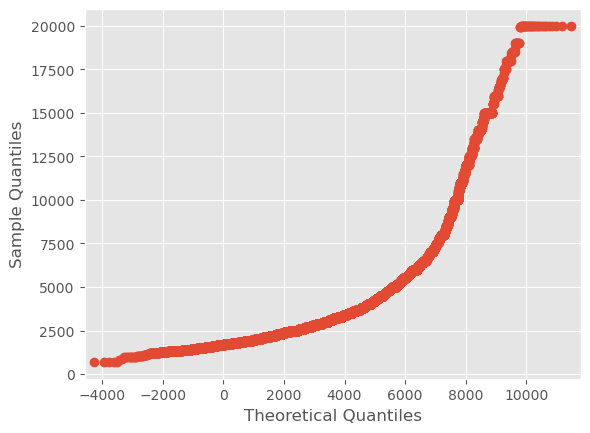

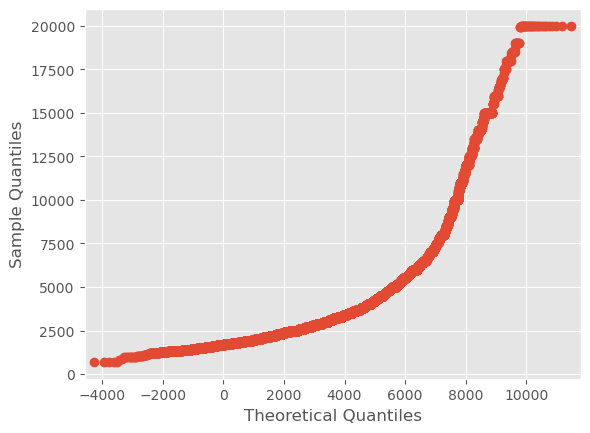

In [27]:
# Побудова Q-Q графіку для перевірки нормальності розподілу ціни
sm.qqplot(price, loc=price.mean(), scale=price.std())

Q-Q графік початкової ознаки.

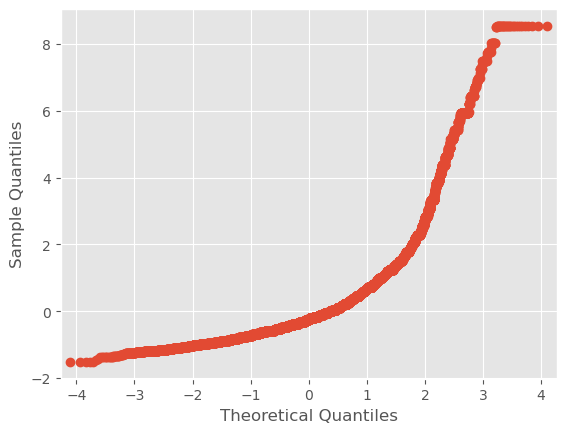

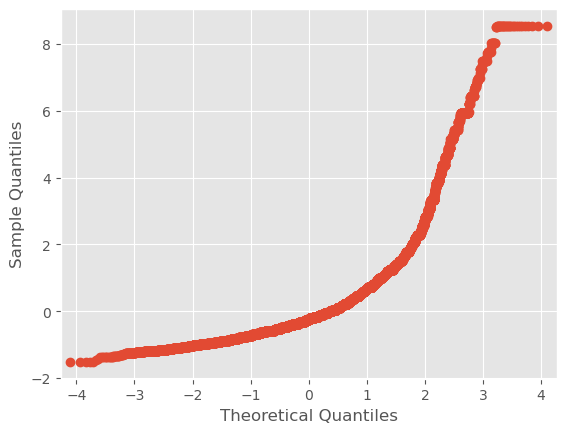

In [28]:
# Побудова Q-Q графіку для стандартизованої ціни для оцінки нормальності
sm.qqplot(price_z, loc=price_z.mean(), scale=price_z.std())

Q-Q графік ознаки після StandardScaler. Форма не змінюється.

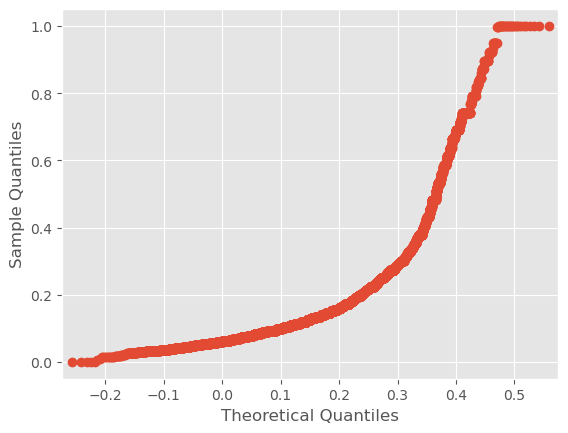

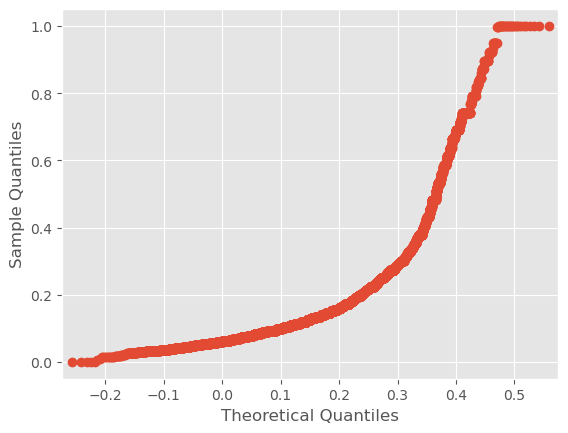

In [29]:
sm.qqplot(price_mm, loc=price_mm.mean(), scale=price_mm.std())

Q-Q графік ознак після MinMaxScaler. Форма не змінюється.

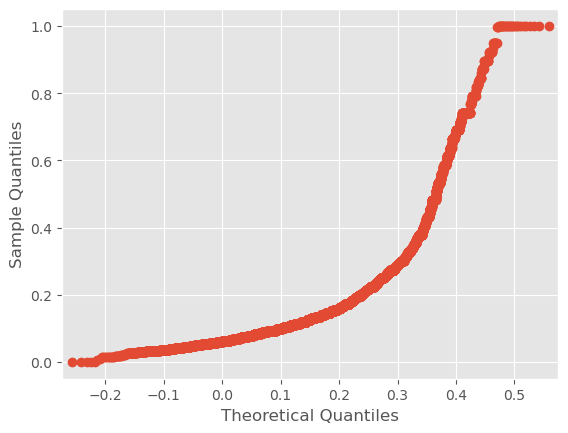

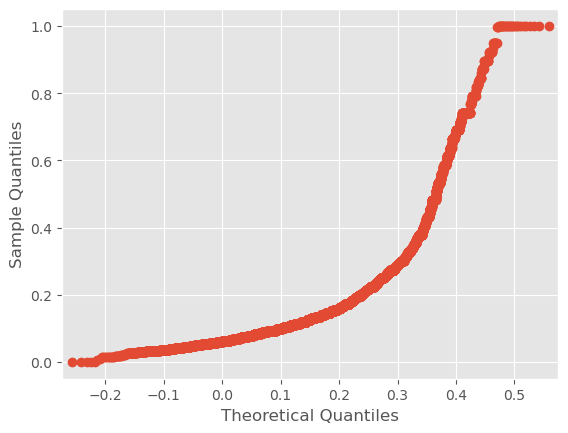

In [30]:
# Побудова Q-Q графіку для нормалізованої ціни 
# (в діапазоні [0, 1]) для оцінки нормальності
sm.qqplot(price_mm, loc=price_mm.mean(), scale=price_mm.std())

Q-Q графік ознаки після логарифмування. Справи пішли на покращення!

<a class="anchor" id="6.2.2"></a>

### <span style="color:blue; font-size:1.2em;">6.2.2. Взаємодії (Interactions)</span>

[Повернутися до змісту](#6)

Якщо попередні перетворення диктувалися швидше математикою, то цей пункт знову обґрунтований природою даних; його можна віднести як до перетворень, так і до створення нових ознак.

Знову звернемося до задачі [Two Sigma Connect: Rental Listing Inquires](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries). Поміж ознак цієї задачі є кількість кімнат і вартість оренди. Життєва логіка підказує, що вартість у перерахунку на одну кімнату є більш показовою, ніж загальна вартість – отже, можна спробувати виділити таку ознаку.

In [31]:
# Замінюємо значення кількості спалень на мінімум 0.5, 
# щоб уникнути ділення на нуль
rooms = df["bedrooms"].apply(lambda x: max(x, 0.5))

# Розраховуємо ціну за спальню, уникаючи поділу на нуль
df["price_per_bedroom"] = df["price"] / rooms

Необов'язково керуватися життєвою логікою. Якщо ознак не дуже багато, можна згенерувати всі можливі взаємодії і потім відсіяти зайві, використовуючи одну з технік, що описані в наступному розділі. Крім того, не всі взаємодії між ознаками повинні мати хоч якийсь фізичний зміст: наприклад, [часто використовувані для лінійних моделей](https://d2l.ai/chapter_linear-networks/linear-regression.html) поліноміальні ознаки (див. [sklearn.preprocessing.PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) трактувати практично неможливо.

<a class="anchor" id="6.2.3"></a>

### <span style="color:blue; font-size:1.2em;">6.2.3. Заповнення пропусків</span>

[Повернутися до змісту](#6)

Мало які алгоритми вміють працювати з пропущеними значеннями "з коробки". Водночас реальний світ часто постачає дані з пропусками. На щастя, це одне з тих завдань, для розв'язання яких не потрібна жодна творчість. Обидві ключові для аналізу даних Python бібліотеки надають прості рішення: [pandas.DataFrame.fillna](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) та [sklearn.preprocessing.Imputer](http://scikit-learn.org/stable/modules/preprocessing.html#imputation).

Готові бібліотечні рішення не ховають жодної магії за фасадом. Підходи до оброблення відсутніх значень напрошуються на рівні здорового глузду:

* закодувати окремим порожнім значенням, як `"n/a"` (для категоріальних змінних);
* використати найімовірніше значення ознаки (середнє або медіану для дійсних змінних, найчастіше для категоріальних);
* навпаки, закодувати якимось неймовірним значенням (добре заходить для моделей, що ґрунтуються на деревах рішень, тому що дозволяє зробити поділ на пропущені та непропущені значення);
* для впорядкованих даних (наприклад, часових рядів) можна брати сусіднє значення – наступне чи попереднє.

<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_6_value-error.png" align="center" width=70%>

Зручність використання бібліотечних рішень іноді підказує вставити щось на зразок `df = df.fillna(0)` і не турбуватися за пропуски. Проте це не найрозумніше рішення: більшість часу зазвичай йде не так на побудову моделі, але на підготовку даних. Бездумне неявне заповнення пропусків може заховати баг в обробленні та зіпсувати модель.

<a class="anchor" id="6.3"></a>

## <span style="color:blue; font-size:1.2em;">6.3. Відбір ознак (Feature selection)</span>

[Повернутися до змісту](#6)

Навіщо взагалі проводити відбір ознак? Комусь ця ідея може здатися контрінтуїтивною, але насправді є щонайменше дві важливі причини позбавлятися неважливих ознак. Перша є зрозумілою кожному інженеру: що більше даних, то вищою є обчислювальна складність. Поки ми працюємо з іграшковими наборами даних, розмір даних не є проблемою. Проте для реального навантаженого комерційного проєкту зайві сотні ознак можуть бути вкрай відчутними. Інша причина – деякі алгоритми сприймають шум (неінформативні ознаки) за цільовий сигнал, узагальнюючи надлишкову або непотрібну інформацію.

<a class="anchor" id="6.3.1"></a>

### <span style="color:blue; font-size:1.2em;">6.3.1 Статистичні підходи</span>

[Повернутися до змісту](#6)

Найочевидніший кандидат на вилучення – це ознака, що має незмінне значення, тобто, така, яка не містить жодної інформації. Якщо трохи відійти від цього виродженого випадку, то можна припустити, що низьковаріативні ознаки є дещо гіршими, ніж високоваріативні. Так можна дійти ідеї вилучати ознаки, дисперсія яких нижче певної межі.

In [32]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification

# Генеруємо синтетичний набір даних для класифікації
x_data_generated, y_data_generated = make_classification()

# Перевіряємо розмірність створених даних (кількість зразків та ознак)
x_data_generated.shape

(100, 20)

In [33]:
from sklearn.feature_selection import VarianceThreshold

# Відбираємо ознаки з дисперсією понад 0.7 за допомогою VarianceThreshold
x_selected = VarianceThreshold(threshold=0.7).fit_transform(x_data_generated)

# Перевіряємо нову розмірність даних після відбору ознак
x_selected.shape

(100, 20)

In [34]:
from sklearn.feature_selection import VarianceThreshold

# Використовуємо VarianceThreshold для відбору ознак з дисперсією понад 0.8
x_selected = VarianceThreshold(threshold=0.8).fit_transform(x_data_generated)

# Перевіряємо розмірність даних після відбору ознак
x_selected.shape

(100, 19)

In [35]:
from sklearn.feature_selection import VarianceThreshold

# Застосовуємо VarianceThreshold для відбору ознак з дисперсією понад 0.9
x_selected = VarianceThreshold(threshold=0.9).fit_transform(x_data_generated)

# Виводимо розмірність даних після відбору ознак
x_selected.shape

(100, 17)

Є й інші підходи, що також [ґрунтуються на класичній статистиці](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

In [36]:
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Відбираємо 5 найкращих ознак за допомогою SelectKBest на основі f-критерію
x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)

# Відбираємо ознаки з дисперсією понад 0.9 за допомогою VarianceThreshold
x_data_varth = VarianceThreshold(threshold=0.9).fit_transform(x_data_generated)

In [37]:
# Виконуємо перехресну перевірку для LogisticRegression 
# з метрикою негативної логарифмічної втрати
log_loss_score = cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='neg_log_loss').mean()
log_loss_score

-0.3293270109192788

In [38]:
cross_val_score(LogisticRegression(), x_data_kbest, y_data_generated, scoring='neg_log_loss').mean()

-0.2988325330278957

In [39]:
cross_val_score(LogisticRegression(), x_data_varth, y_data_generated, scoring='neg_log_loss').mean()

-0.3676902831465343

Бачимо, що відібрані ознаки підвищили якість класифікатора. Зрозуміло, що цей приклад є штучним, проте підхід гідний уваги і в реальних завданнях.

<a class="anchor" id="6.3.2"></a>

### <span style="color:blue; font-size:1.2em;">6.3.2. Відбір із використанням моделей</span>

[Повернутися до змісту](#6)

Інший підхід: використовувати певну базову модель для оцінювання ознак. Водночас модель повинна явно демонструвати важливість використаних ознак. Зазвичай використовуються два типи моделей: якийсь "дерев'яний" ансамбль (наприклад, [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) або лінійна модель з [Lasso регуляризацією](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), яка схильна обнулювати ваги слабких ознак. Логіка інтутивно зрозуміла: якщо ознаки явно марні в простій моделі, то не треба залишати їх і в складній.

In [40]:
# Імпортуємо необхідні бібліотеки
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [41]:
# Генеруємо синтетичний набір даних для задачі класифікації
x_data_generated, y_data_generated = make_classification()

# Створюємо конвеєр, що включає відбір ознак на основі RandomForest та LogisticRegression
pipe = make_pipeline(SelectFromModel(estimator=RandomForestClassifier()), LogisticRegression())

# Ініціалізуємо окремо логістичну регресію та випадковий ліс
lr = LogisticRegression()
rf = RandomForestClassifier()

# Оцінюємо середнє значення негативної логарифмічної втрати (neg_log_loss) для кожної моделі
print(f"LR (без відбору ознак): {cross_val_score(lr, x_data_generated, y_data_generated, scoring='neg_log_loss').mean()}")
print(f"RF (без відбору ознак): {cross_val_score(rf, x_data_generated, y_data_generated, scoring='neg_log_loss').mean()}")
print(f"LR + відбір ознак (на основі RF): {cross_val_score(pipe, x_data_generated, y_data_generated, scoring='neg_log_loss').mean()}")

LR (без відбору ознак): -0.2580620983508194
RF (без відбору ознак): -0.2601662484824064
LR + відбір ознак (на основі RF): -0.19747304979931118


Варто також розуміти, що такий підхід теж не срібна куля – може вийти навіть гірше.

In [42]:
# Використовуємо згенеровані дані для імітації набору Renthop
x_data = x_data_generated
y_data = y_data_generated

# Конвеєр з масштабуванням, відбором ознак на основі RandomForest, та LogisticRegression
pipe1 = make_pipeline(StandardScaler(), SelectFromModel(estimator=RandomForestClassifier()), LogisticRegression())
# Конвеєр з лише масштабуванням та LogisticRegression без відбору ознак
pipe2 = make_pipeline(StandardScaler(), LogisticRegression())
# Модель випадкового лісу без додаткових конвеєрів
rf = RandomForestClassifier()

In [43]:
# Оцінка моделей за середньою негативною логарифмічною втратою (neg_log_loss)
print(f"LR + відбір ознак: "
      f"{cross_val_score(pipe1, x_data, y_data, scoring='neg_log_loss').mean()}")
print(f"LR (без відбору ознак): "
      f"{cross_val_score(pipe2, x_data, y_data, scoring='neg_log_loss').mean()}")
print(f"RF (без додаткової обробки): "
      f"{cross_val_score(rf, x_data, y_data, scoring='neg_log_loss').mean()}")

LR + відбір ознак: -0.20312523710113975
LR (без відбору ознак): -0.2738830725154988
RF (без додаткової обробки): -0.24578048768716104


Стало лише гірше!

<a class="anchor" id="6.3.3"></a>

### <span style="color:blue; font-size:1.2em;"> 6.3.3. Перебір</span>

[Повернутися до змісту](#6)

В решті-решт, найнадійніший, але й найбільш обчислювально складний спосіб ґрунтуються на звичайному переборі:
* навчаємо модель на підмножині "ознак";
* запам'ятовуємо результат;
* повторюємо для різних підмножин;
* порівнюємо якість моделей.

Такий підхід називається [Exhaustive Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/).

Перебирати всі комбінації зазвичай занадто довго, так що можна пробувати зменшити простір перебору:
1. Фіксуємо невелике число N.
2. Перебираємо всі комбінації за ознаками N.
3. Вибираємо кращу комбінацію.
4. Далі перебираємо комбінації з N+1 ознак так, що попередня краща комбінація ознак зафіксована, а перебирається тільки нова ознака.

Отже, так можна перебирати, допоки не впораємося в максимально допустиму кількість ознак або поки якість моделі не перестане значно зростати. Цей алгоритм називається [Sequential Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/).

Деталізуємо описаний вище алгоритм: починати з повного простору ознак і викидати ознаки по одній, поки якість моделі залишається сталою або поки не досягнуто бажану кількість ознак.

In [44]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

# Ініціалізація послідовного відбору ознак (backward selection)
selector = SequentialFeatureSelector(LogisticRegression(), 
                                     scoring='neg_log_loss',      # Використовуємо метрику негативної логарифмічної втрати
                                     verbose=2,                   # Вивід деталей процесу відбору
                                     k_features=3,                # Відбираємо 3 найкращі ознаки
                                     forward=False,               # Вибираємо режим backward selection
                                     n_jobs=-1)                   # Використовуємо всі ядра процесора для паралельної обробки

# Навчаємо селектор на даних
selector.fit(x_data, y_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    3.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.0s finished

[2024-11-07 11:17:07] Features: 19/3 -- score: -0.23311307232030126[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.0s finished

[2024-11-07 11:17:08] Features: 18/3 -- score: -0.21527474509950748[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished

[2024-11-07 11:17:08] Features: 17/3 -- score: -0.20501478982817645[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out 

SequentialFeatureSelector(estimator=LogisticRegression(), forward=False,
                          k_features=(3, 3), n_jobs=-1, scoring='neg_log_loss',
                          verbose=2)

Можемо переглянути як цей підхід був реалізований в одному простому, але елегантному [ядрі Kaggle](https://www.kaggle.com/arsenyinfo/easy-feature-selection-pipeline-0-55-at-lb).

<a class="anchor" id="6.4"></a>

## <span style="color:blue; font-size:1.2em;">6.4. Основні метрики якості класифікації</span>

[Повернутися до змісту](#6)

<a class="anchor" id="6.4.1"></a>

### <span style="color:blue; font-size:1.2em;">6.4.1. Матриця невідповідностей</span>

[Повернутися до змісту](#6)

Існує багато метрик, що дають змогу обчислити кількісну характеристику бінарного класифікатора. У випадку віднесення одного об'єкта до одного з двох класів можливі 4 результати. Їх зручно відображати за допомогою матриці невідповідностей (з англ. "[confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)"):

- $TP$ – кількість правильно класифікованих цільових об'єктів;
- $FP$ – кількість нецільових об'єктів, що класифіковані як цільові (помилки першого роду);
- $TN$ – кількість правильно класифікованих нецільових прикладів;
- $FN$ – кількість цільових об'єктів, що класифіковані як нецільові (помилки другого роду).

<figure>
<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_8_confusion-matrix.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><i>Джерело: https://encord.com/glossary/confusion-matrix/</i></figcaption>
</figure>

Отримати таку таблицю можна за допомогою функції [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Необхідно їй на вхід передати дійсні та передбачені класифікатором мітки.

In [45]:
from sklearn import metrics

# Істинні та передбачені мітки класів
true_labels = np.array([0, 1, 0, 0, 1, 1, 1, 1])
predicted_labels = np.array([0, 1, 1, 0, 0, 1, 0, 0])

# Обчислення матриці плутанини
my_metrics = metrics.confusion_matrix(true_labels, predicted_labels)
print("Матриця плутанини:\n", my_metrics)

Матриця плутанини:
 [[2 1]
 [3 2]]


<a class="anchor" id="6.4.2"></a>

### <span style="color:blue; font-size:1.2em;">6.4.2. Характеристики бінарного класифікатора</span>

[Повернутися до змісту](#6)

З огляду на таблицю вище, введемо кілька величин, що кількісно характеризують бінарний класифікатор:

$$Recall = TPR = \frac{TP}{TP + FN},$$


$$\quad SPC = \frac{TN}{TN + FP},$$


$$\quad Precision = PPV = \frac{TP}{TP + FP},$$


$$\quad FPR = 1 - SPC,$$


$$ACC = \frac{TP + TN}{TP + TN + FP + FN},$$


$$\quad F1 = 2\frac{PPV\cdot TRP}{PPV + TPR}.$$


Повнота $TPR$ (True positive rate, recall, sensitivity) – частка правильно класифікованих цільових об'єктів поміж усіх цільових об'єктів.

Специфічність $SPC$ (Specificity, true negative rate) – частка правильно класифікованих нецільових об'єктів поміж усіх нецільових об'єктів.

Влучність $PPV$ (Positive predictive value, precision) – частка правильно класифікованих цільових об'єктів поміж усіх об'єктів, що класифіковані праильно.

$FPR$ (False positive rate) – частка помилково класифікованих нецільових об'єктів поміж усіх нецільових об'єктів.

$ACC$ (Accuracy) – частка правильно класифікованих об'єктів поміж усіх об'єктів. $ACC$ є основною характеристикою якості класифікації.

$F1$ (F1-measure) – середнє гармонійне влучності та повноти; ця метрика дає змогу врахувати обидві характеристики одночасно.

In [46]:
from sklearn import metrics

# Обчислення метрик для оцінки класифікаційної моделі
PPV = metrics.precision_score(true_labels, predicted_labels)  # Точність (Positive Predictive Value)
TPR = metrics.recall_score(true_labels, predicted_labels)     # Повнота (True Positive Rate)
F1 = metrics.f1_score(true_labels, predicted_labels)          # F1-міра
ACC = metrics.accuracy_score(true_labels, predicted_labels)   # Точність класифікації (Accuracy)

# Виведення результатів
PPV, TPR, F1, ACC

(0.6666666666666666, 0.4, 0.5, 0.5)

<a class="anchor" id="6.4.3"></a>

### <span style="color:blue; font-size:1.2em;">6.4.3. ROC-крива та AUC</span>

[Повернутися до змісту](#6)

Здебільшого бінарні класифікатори мають вигляд $a(x) = \mbox{sign}(f(x, w) - w_0)$, де $w, w_0$ – параметри алгоритму. Тобто спочатку будується розділяюча поверхня $f(x, w) = w_0 $, після чого об'єкти, що перебувають з однієї сторони від неї класифікуються як цільові, з іншої – як нецільові.

ROC-крива (Receiver Operating Characteristic) – це графічна характеристика якості бінарного класифікатора, що виражає залежність TPR від FPR при зміні порога вирішального правила. Ця крива ілюструє, якою буде якість класифікації за різних значень $w_0$ і фіксованому значенні $w$.

ROC-крива проходить через точки (0, 0) та (1, 1) і монотонно не зменшується. Чим ближче крива всередині квадрата $[0, 1]\times[0, 1]$ до лівого верхнього кута, тим краще. Ідеальний варіант – крива, що проходить через три точки: (0, 0), (1, 1) та (0, 1). Діагональ цього квадрата відповідає випадковій класифікації. Типова ROC-крива для класифікатора відповідає кривій на рисунку нижче.

<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/6_9_ROC.jpg" align="center" width=50%>

На практиці ROC-криву завжди оцінюють за незалежною тестовою вибіркою, щоб уникнути перенавчання.

Площа під ROC-кривою AUC (Area Under Curve) є кількісною характеристикою якості класифікації, яка не залежить від співвідношення помилок. Чим більше значення AUC, тим "краще" є модель класифікації.

<a class="anchor" id="6.4.4"></a>

### <span style="color:blue; font-size:1.2em;">6.4.4. Дисбаланс класів</span>

[Повернутися до змісту](#6)

На практиці у разі дисбалансу класів вдаються до таких [дій](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/):

- зібрати більше даних, особливо об'єктів рідкісного класу (не завжди можливо);
- використовувати методи, що ґрунтуються на деревах рішень – [випадковий ліс](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) або [градієнтний бустинг над деревами](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html); дерева не так схильні до проблеми дисбалансу класів;
- використовувати метрики типу $F_1$, ROC AUC та [Cohen's kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa), а не ACC;
- використовувати метрику, в якій помилка на об'єкті з рідкісного класу входить із більшою вагою, ніж помилка на об'єкті з типового класу;
- застосовувати [oversampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) та [undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis); у першому випадку до вибірки додаються об'єкти рідкісного класу (семплюються із заміщенням), у другому – об'єкти типового класу випадково видаляються з вибірки;
- згенерувати штучні об'єкти рідкісного класу, Synthetic Minority Over-sampling Technique ([SMOTE](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn)); додаткова [реалізація](https://github.com/fmfn/UnbalancedDataset) на Python;
- розбити один великий клас на кілька менших та застосувати стратегії [One Vs. All](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/) або [One Vs. One](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/);
- застосувати алгоритми пошуку викидів або OneClass алгоритми (наприклад, [OneClass SVM](https://machinelearningmastery.com/one-class-classification-algorithms/)).

<a class="anchor" id="6.4.5"></a>

### <span style="color:blue; font-size:1.2em;">6.4.5. Приклади застосувань метрик класифікації</span>

[Повернутися до змісту](#6)

In [47]:
import sys
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn import datasets
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Перевірка версії Python для правильного імпорту функції urlopen
if sys.version_info.major == 2:
    from urllib import urlopen
elif sys.version_info.major == 3:
    from urllib.request import urlopen

In [48]:
# Завантажуємо дані щодо діабету індіанців Піма зі сховища машинного навчання UCI
pima_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/01_lecture-notes/ida_lecture-06_feature-engineering/pima_diabetes.csv'
data = pd.read_csv(pima_url, delimiter=",")

# Вибираємо ознаки (X) та цільову змінну (y)
X = data.iloc[:, :8]  # Перші 8 стовпців — це ознаки
y = data.iloc[:, 8]   # Останній стовпець — це цільова змінна
# Розбиваємо дані на тренувальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Встановлюємо параметр регуляризації для терміну помилки
C = 10.0

In [49]:
# Створюємо та навчаємо класифікатор Support Vector Machine (лінійний)
lin_svm = LinearSVC(C=C, dual=False).fit(X_train, y_train)

# Отримуємо оцінки для тестових даних (деякі значення ймовірності для обчислення ROC)
y_score = lin_svm.decision_function(X_test)

# Обчислюємо ROC-криву та значення площі під кривою (ROC AUC)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

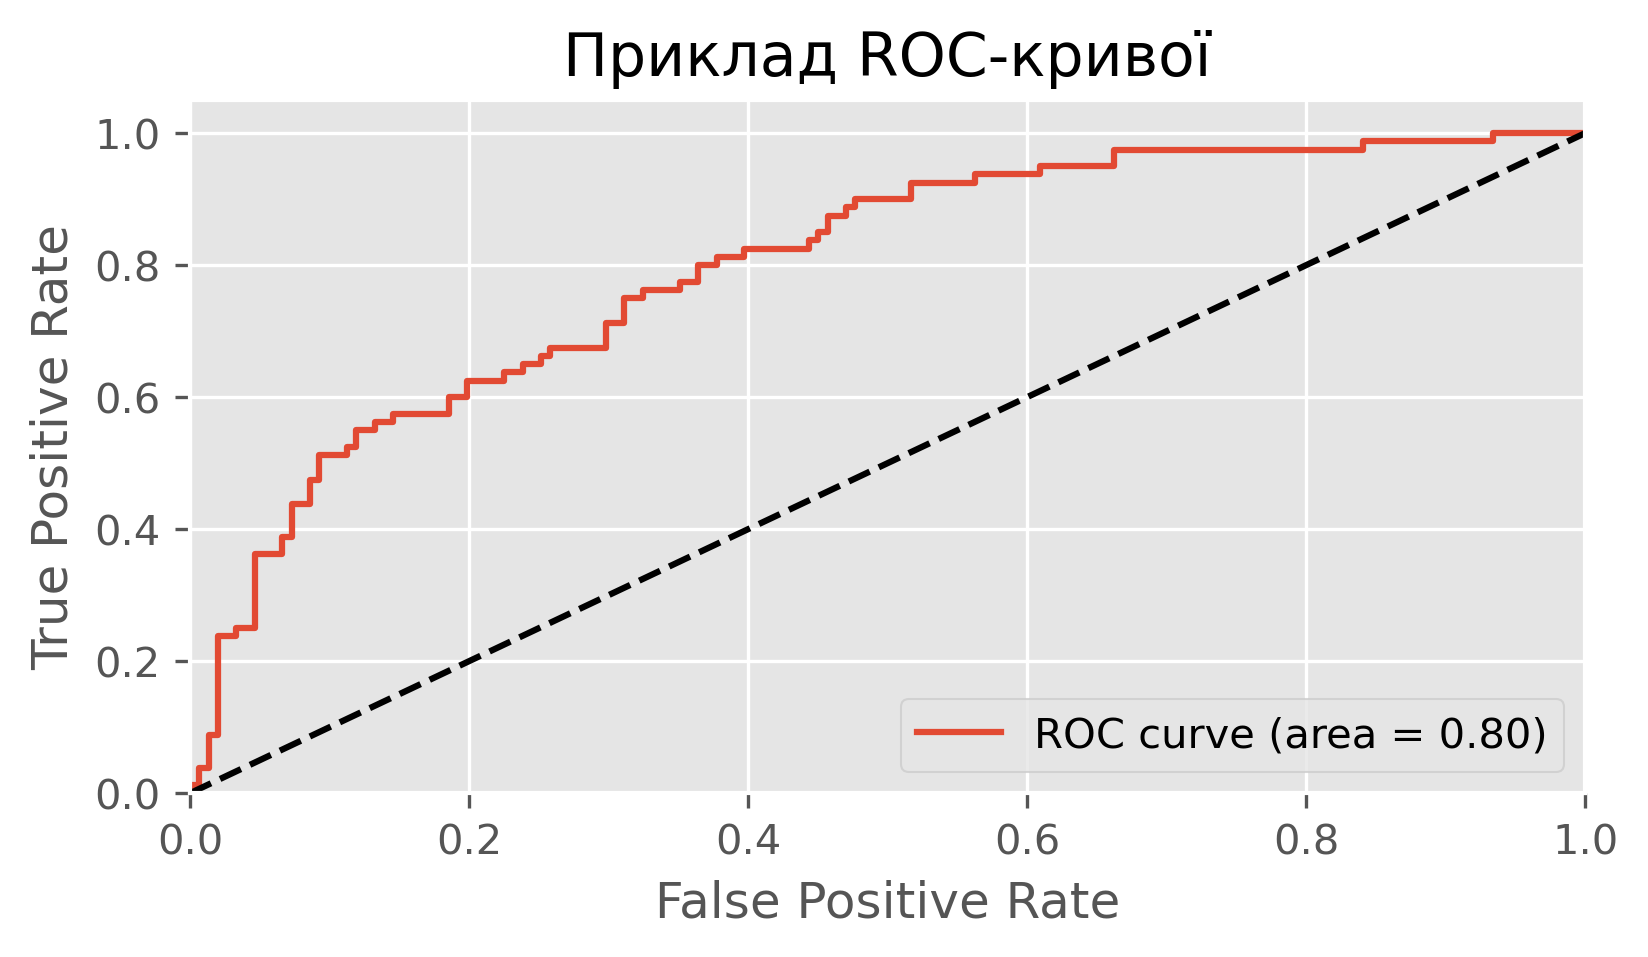

In [50]:
plt.figure(1, figsize=(6, 3), dpi=300)
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Приклад ROC-кривої")
plt.legend(loc="lower right"); plt.show()

Вказані вище характеристики можна використовувати для підбору параметрів алгоритмів, наприклад, за допомогою крос-валідації. Знайдемо оптимальну з погляду $F_1$-міри кількість найближчих сусідів алгоритму $kNN$.

In [51]:
# Масив значень k (кількість сусідів), для яких обчислюємо F1-міру
k_values = np.arange(1, 50, 2)

# Обчислюємо середній F1-скор для кожного значення k за допомогою перехресної перевірки
scores_f1 = [cross_val_score(KNeighborsClassifier(n_neighbors=k), 
                             X, 
                             y, 
                             scoring="f1").mean() for k in k_values]


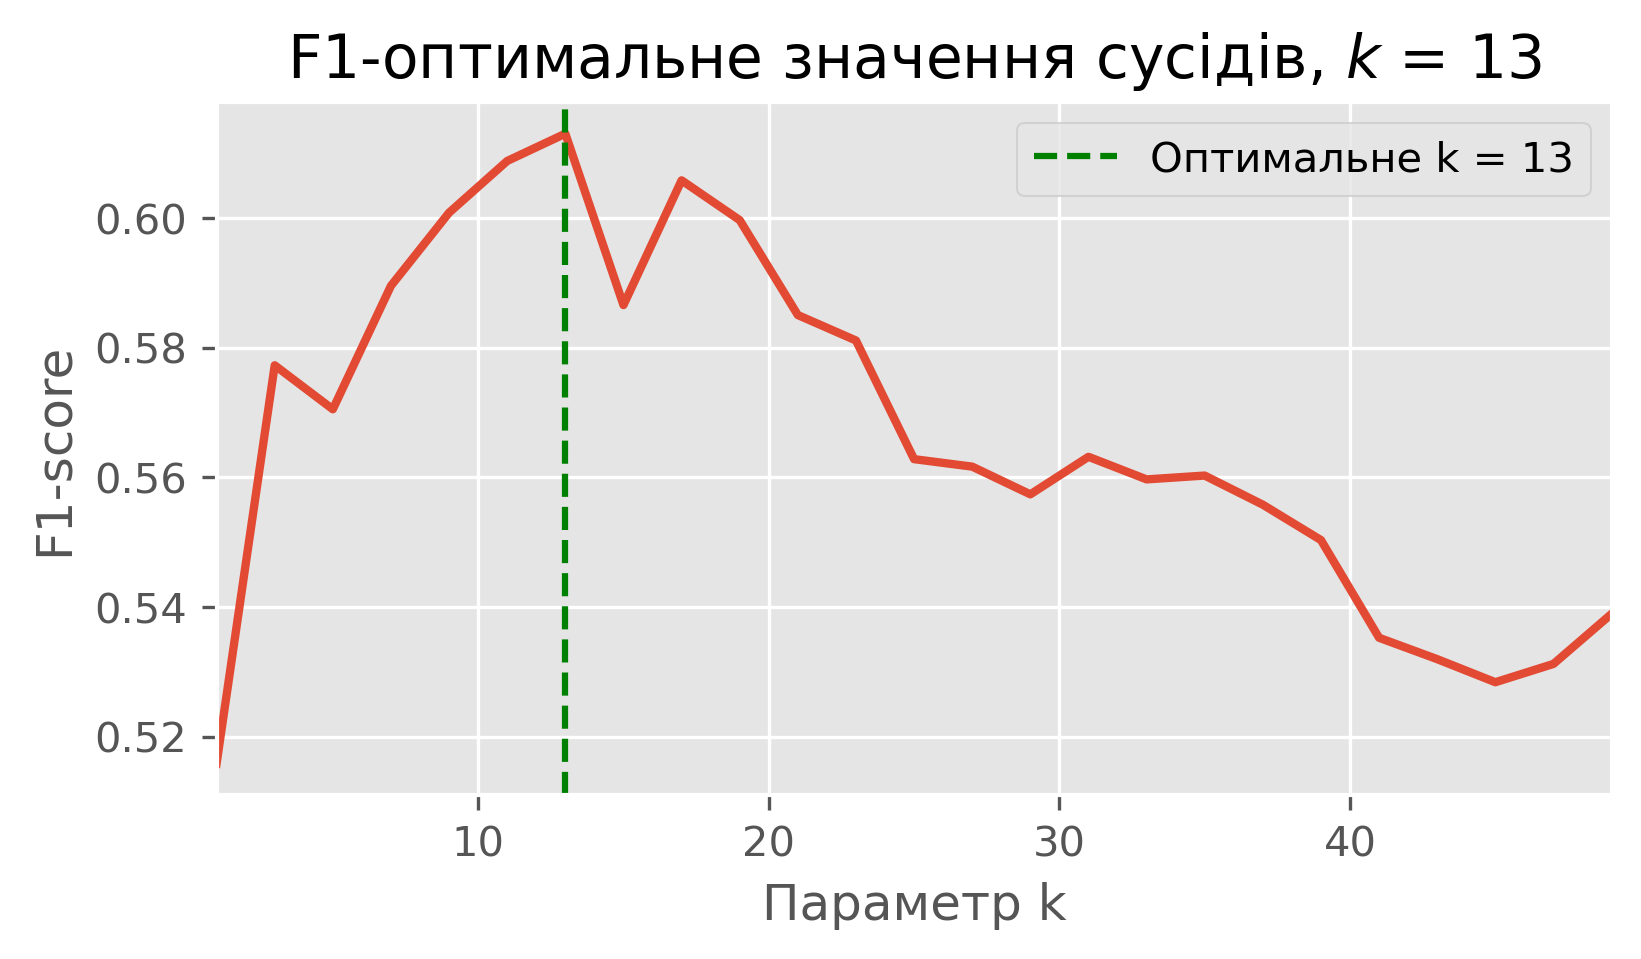

In [56]:
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(k_values, scores_f1, linewidth=2)
plt.axvline(k_values[np.argmax(scores_f1)], color="g", linestyle="--", 
            label=f"Оптимальне k = {k_values[np.argmax(scores_f1)]}")
plt.xlabel("Параметр k"); plt.ylabel("F1-score")
plt.title("F1-оптимальне значення сусідів, $k$ = %d" % k_values[np.argmax(scores_f1)])
plt.xlim(1, 49)
plt.legend(loc="best");plt.show()

<a class="anchor" id="6.4.6"></a>

### <span style="color:blue; font-size:1.2em;">6.4.6. Багатокласова класифікація</span>

[Повернутися до змісту](#6)

У разі, коли кількість класів більше двох, матриця невідповідностей визначається аналогічним чином: на перетині $i$-го рядка і $j$-го стовпця стоїть кількість об'єктів $i$-го класу, що відносяться класифікатором до класу $j$.

In [57]:
true_labels = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
predicted_labels = np.array([0, 2, 0, 2, 1, 0, 0, 1, 2])

my_metrics2 = metrics.confusion_matrix(true_labels, predicted_labels)
my_metrics2

array([[2, 0, 1],
       [0, 2, 1],
       [2, 0, 1]], dtype=int64)

<a class="anchor" id="6.4.7"></a>

### <span style="color:blue; font-size:1.2em;">6.4.7. One vs. All</span>

[Повернутися до змісту](#6)

**Багатокласова класифікація з підходом One vs. All**

- **Суть методу:** багатокласову задачу зводимо до кількох бінарних.

- **One vs. All:** для кожного класу 
  $$i \in \{1, \dots, k\}$$ 
  навчаємо бінарний класифікатор 
  $$a_i(x) = \text{sign}(f_i(x)),$$
  де:
  - Об'єкти класу $i$ отримують мітку $1,$
  - Об'єкти всіх інших класів отримують мітку $0.$


- **Мета навчання:** класифікатор $a_i$ вчиться розрізняти клас $i$ від усіх інших.

- **Фінальний прогноз:** після навчання бінарних класифікаторів, обираємо клас із найбільшою оцінкою:
  
  $$a(x) = \arg\max_{i \in \{1, \dots, k\}} f_i(x).$$

- **Детальніше:** [One vs. All](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/one-vs-all).

In [58]:
from sklearn import datasets, metrics

iris = datasets.load_iris()
X, y = iris.data, iris.target

# Масштабування ознак та підлаштування моделі
onevsall = OneVsRestClassifier(make_pipeline(StandardScaler(), LinearSVC(max_iter=10000, C=1.0))).fit(X, y)
accuracy_svc = metrics.accuracy_score(y, onevsall.predict(X))

print(f"Точність класифікації: {accuracy_svc:.7f}")

Точність класифікації: 0.9466667


<a class="anchor" id="6.5"></a>

## <span style="color:blue; font-size:1.2em;">6.5. Корисні посилання</span>

[Повернутися до змісту](#6)

- [Конструювання ознак](https://uk.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BD%D1%81%D1%82%D1%80%D1%83%D1%8E%D0%B2%D0%B0%D0%BD%D0%BD%D1%8F_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA) [UKR].
- [Feature extraction from scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html#) [ENG].
- [Feature importance from scikit-learn](https://scikit-learn.org/stable/modules/permutation_importance.html) [ENG].
- [Feature selection from scikit-learn](https://scikit-learn.org/stable/modules/feature_selection.html) [ENG].
- [Feature selection from scikit-learn. Examples](https://scikit-learn.org/stable/auto_examples/index.html#feature-selection) [ENG].
- [Feature Engineering for Machine Learning](https://www.repath.in/gallery/feature_engineering_for_machine_learning.pdf) *by Alice Zheng & Amanda Casari* [ENG].
- [The Ultimate Guide to 12 Dimensionality Reduction Techniques (with Python codes)](https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/) [ENG].
- [How to improve the accuracy of a classification model?](https://analyticsindiamag.com/how-to-improve-the-accuracy-of-a-classification-model/) [ENG].
- [Матриця невідповідностей](https://uk.wikipedia.org/wiki/%D0%9C%D0%B0%D1%82%D1%80%D0%B8%D1%86%D1%8F_%D0%BD%D0%B5%D0%B2%D1%96%D0%B4%D0%BF%D0%BE%D0%B2%D1%96%D0%B4%D0%BD%D0%BE%D1%81%D1%82%D0%B5%D0%B9) [UKR].
- [ROC-криві. Оглядова стаття](https://dou.ua/forums/topic/33858/) [UKR].
- 8 тактик боротьби з незбалансованими класами у вашому наборі даних машинного навчання на [Machine Learning Mastery](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) [ENG].